In [1]:
import sandbox_fm.depth
import sandbox_fm.sandbox_fm
import sandbox_fm.calibrate
import bmi.wrapper
import pathlib
import matplotlib.pyplot as plt
import sandbox_fm.plots
import numpy as np
import scipy.stats
import matplotlib.collections
import json
import cv2


%matplotlib inline

No kinect found, using test images


Error: Can't open device. 1.) is it plugged in? 2.) Read the README


In [2]:
with open('../config.json') as f:
    config = json.load(f)
with open('../calibration.json') as f:
    calibration = json.load(f)

In [3]:
videos = sandbox_fm.depth.video_images()
depths = sandbox_fm.depth.depth_images()
depth_0 = next(depths).astype('float32')
video_0 = next(videos)

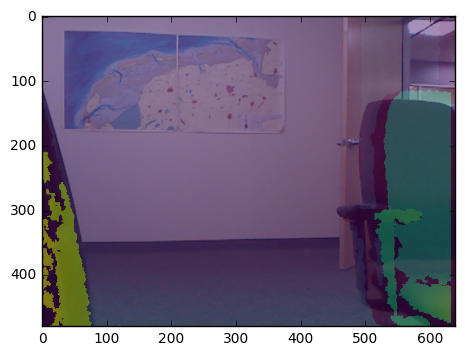

In [4]:
plt.imshow(video_0, cmap='viridis')
plt.imshow(depth_0, cmap='viridis', alpha=0.5)

In [5]:
depth = next(depths).astype('float32')

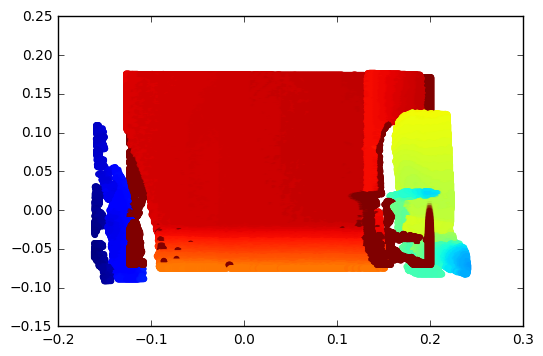

In [6]:
xyz, uv = sandbox_fm.calibrate.depth2xyzuv(depth)
plt.scatter(-xyz[:, 1], -xyz[:, 0], c=xyz[:, 2], edgecolor='none')

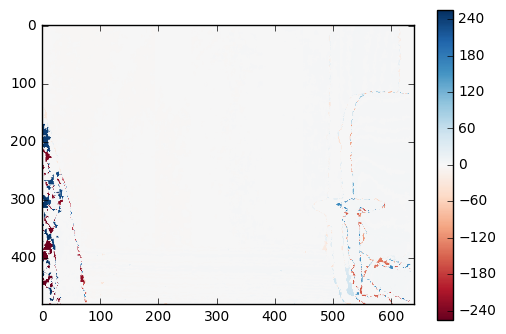

In [7]:
vmax = (depth - depth_0).max()
vmin = -vmax
plt.imshow(depth - depth_0, matplotlib.cm.RdBu, vmin=vmin, vmax=vmax)
plt.colorbar()

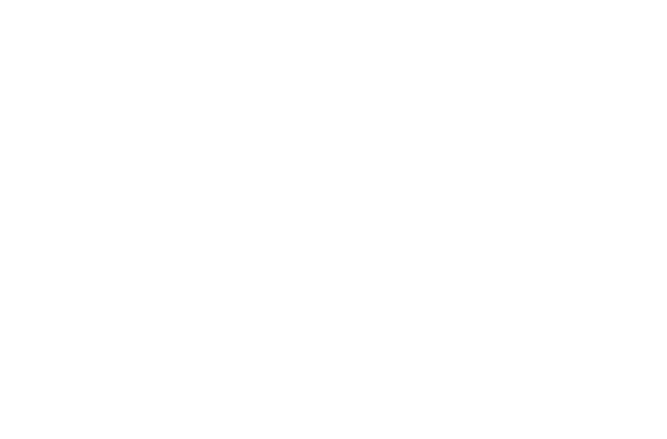

In [8]:
vis = sandbox_fm.plots.Visualization()

In [9]:

model = bmi.wrapper.BMIWrapper('dflowfm')
path = pathlib.Path('../tests/FM_zandbak_update_PV_v1/zm_v2.mdu')
# make sure to pass absolute path
model.initialize(str(path.absolute()))


In [10]:
# initial data
data = {}
data.update(calibration)
data['kinect_0'] = depth_0,
data['kinect'] = depth,
sandbox_fm.sandbox_fm.update_delft3d_initial_vars(data, model)


In [11]:
data.keys()

dict_keys(['model2box', 'yk', 'flowelemnode', 'xk', 'ndx', 'img_points', 'bl_0', 'model_points', 'ndxi', 'kinect_0', 'kinect', '_comment', 'xzw', 'zk', 'numk', 's1_0', 'img2box', 'yzw', 'img2model', 'box2model', 'box2img', 'model2img'])

In [12]:
for i in range(100):
    model.update()
sandbox_fm.sandbox_fm.update_delft3d_vars(data, model)


In [13]:
model_bbox = matplotlib.path.Path(data['model_points'])

data['node_in_box'] = model_bbox.contains_points(np.c_[data['xk'], data['yk']])
data['cell_in_box'] = model_bbox.contains_points(np.c_[data['xzw'], data['yzw']])

xk_box, yk_box = sandbox_fm.calibrate.transform(data['xk'], data['yk'], data['model2box'])
xzw_box, yzw_box = sandbox_fm.calibrate.transform(data['xzw'], data['yzw'], data['model2box'])
xzw_ucx_box, yzw_ucx_box = sandbox_fm.calibrate.transform(data['xzw'] + data['ucx'], data['yzw'] + data['ucy'], data['model2box'])
ucx_box, ucy_box = xzw_ucx_box - xzw_box, yzw_ucx_box - yzw_box


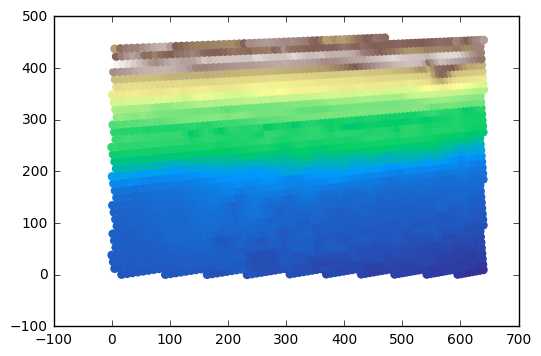

In [14]:
plt.scatter(
    xk_box[data['node_in_box']], 
    yk_box[data['node_in_box']], 
    c=data['zk'][data['node_in_box']], 
    edgecolor='none',
    cmap='terrain',
    s=40
)

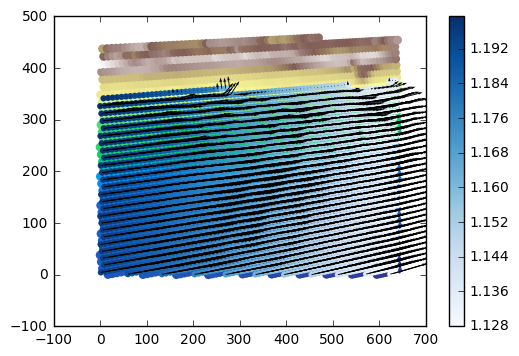

In [15]:

plt.scatter(
    xk_box[data['node_in_box']], 
    yk_box[data['node_in_box']], 
    c=data['zk'][data['node_in_box']], 
    edgecolor='none',
    cmap='terrain',
    s=40
)
idx = np.logical_and(data['cell_in_box'], data['is_wet'])
plt.scatter(
    xzw_box[idx], 
    yzw_box[idx], 
    c=data['s1'][idx], 
    edgecolor='none',
    cmap='Blues'    
)
plt.colorbar()
plt.quiver(
    xzw_box[idx], yzw_box[idx], 
    ucx_box[idx], ucy_box[idx],
    units='xy',
    scale=0.001
)

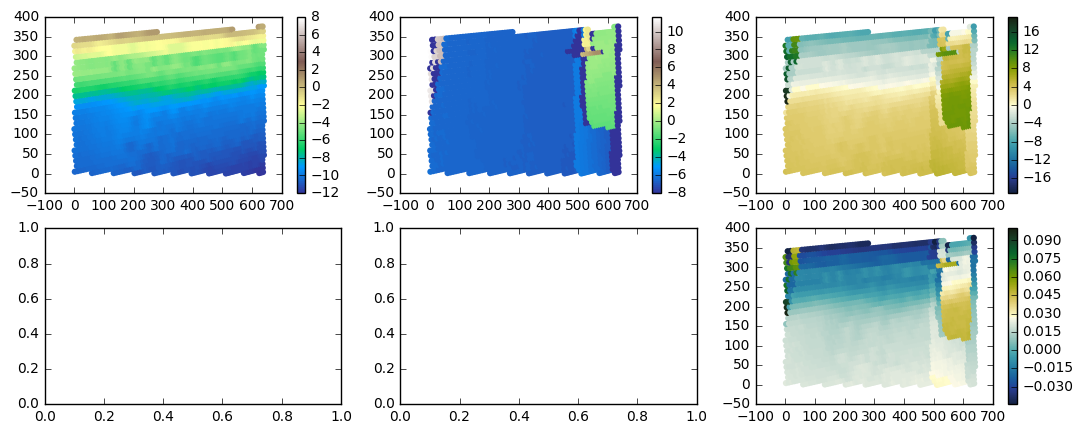

In [65]:
import cmocean.cm
def compute_bathymetry_change(data):
    HEIGHT, WIDTH = sandbox_fm.calibrate.HEIGHT, sandbox_fm.calibrate.WIDTH
    u = np.clip(np.round(yzw_box[idx]).astype('int'), 0, HEIGHT-1)
    v = np.clip(np.round(xzw_box[idx]).astype('int'), 0, WIDTH-1)
    # define the interpolation function from depth to meters
    depth2meters = scipy.interpolate.interp1d([0, 127, 255], [-8, 0, 12])
    cell_depth = depth2meters(depth[u, v].ravel())

    delta_bl = cell_depth - data['bl'][idx]
    max_delta_bl = np.max(np.abs(delta_bl))
    normalized_delta_bl = delta_bl/max_delta_bl
    # limit the bathymetry change per timestep to 0.1
    normalized_delta_bl *= min(max_delta_bl, 0.1)
    return normalized_delta_bl


fig, axes = plt.subplots(2, 3, figsize=(13, 5))
sc = axes[0, 0].scatter(xzw_box[idx], yzw_box[idx], c=data['bl'][idx], edgecolor='none', vmin=-12, vmax=8, cmap='terrain')
plt.colorbar(sc, ax=axes[0, 0])
sc = axes[0, 1].scatter(xzw_box[idx], yzw_box[idx], c=cell_depth, edgecolor='none', cmap='terrain')
plt.colorbar(sc, ax=axes[0, 1])
sc = axes[0, 2].scatter(xzw_box[idx], yzw_box[idx], c=delta_bl, edgecolor='none', cmap=cmocean.cm.delta, vmin=-delta_bl.max(), vmax=delta_bl.max())
plt.colorbar(sc, ax=axes[0, 2])
sc = axes[1, 2].scatter(xzw_box[idx], yzw_box[idx], c=normalized_delta_bl, edgecolor='none', cmap=cmocean.cm.delta)
plt.colorbar(sc, ax=axes[1, 2])



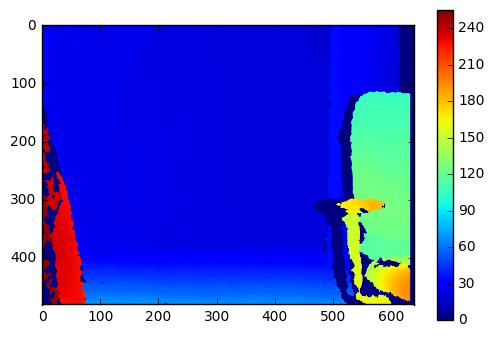

In [19]:
plt.imshow(depth)
plt.colorbar()


new_zk = depth[yk_box[data['node_in_box']].astype('int'), xk_box[data['node_in_box']].astype('int')]
data['zk'][data['node_in_box']] = new_zk


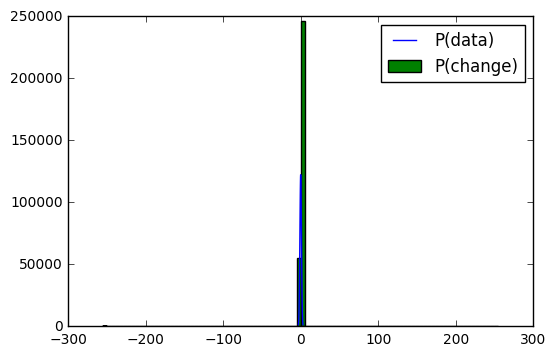

In [20]:
# let's use a normal probability distribution to compute the likelyhood of a change. This is our prior.
# This is our P(change)  in P(change|data) = P(data|change)P(change)/P(data)
# 
P = scipy.stats.norm(0.0, 1.0)
x = np.linspace(-3, 3)
plt.plot(x, P.pdf(x)*len(depth.ravel()), label='P(data)')
_ = plt.hist(depth.ravel() - depth_0.ravel(), bins=100, label='P(change)')
plt.legend()

(450000, 450500)

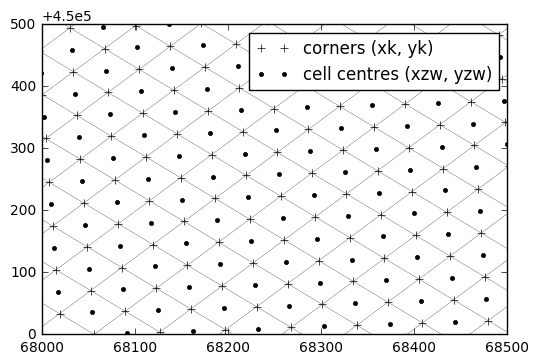

In [16]:
fig, ax = plt.subplots()
ax.plot(data['xk'], data['yk'], 'k+', label='corners (xk, yk)')
ax.plot(data['xzw'], data['yzw'], 'k.', label='cell centres (xzw, yzw)')
xcc = data['xk'][data['flowelemnode']-1]
ycc = data['yk'][data['flowelemnode']-1]
polys = matplotlib.collections.PolyCollection(np.dstack([xcc, ycc]), facecolor='none', linewidth=0.1)
ax.add_collection(polys)
plt.legend()
plt.xlim(68000, 68500)
plt.ylim(450000, 450500)

In [17]:
vis.initialize(data)

KeyError: 'xy_cells_model_in_img'

In [ ]:
img_in_img = np.array([
    [0, 0],
    [0, img.shape[0]],
    [img.shape[1], img.shape[0]],
    [img.shape[1], 0]
    
], dtype='float32')
img2model = cv2.getPerspectiveTransform(img_in_img, img_in_model)
model2img = cv2.getPerspectiveTransform(img_in_model, img_in_img)

In [ ]:
X_model, Y_model = cv2.perspectiveTransform(np.dstack([X_img, Y_img]).astype('float32'), img2model).T


In [ ]:
plt.plot(X_model.ravel(), Y_model.ravel(), 'k.')

In [ ]:
plt.imshow(cv2.warpPerspective(img, img2model, (1320, 1320)))

In [ ]:
xy_cells_model_in_img = np.squeeze(
    cv2.perspectiveTransform(
        np.dstack([
            xy_cells_model[:,np.newaxis,0], 
            xy_cells_model[:,np.newaxis,1]
        ]).astype('float32'), 
        model2img
    )
)
xy_corners_model_in_img = np.squeeze(
    cv2.perspectiveTransform(
        np.dstack([
            xy_corners_model[:,np.newaxis,0], 
            xy_corners_model[:,np.newaxis,1]
        ]).astype('float32'), 
        model2img
    )
)
                             

In [ ]:
plt.plot(xy_cells_model_in_img[:,0], xy_cells_model_in_img[:,1], 'k.', markersize=0.1)
plt.plot(xy_corners_model_in_img[:,0], xy_corners_model_in_img[:,1], 'k+', markersize=0.1)